<a href="https://colab.research.google.com/github/jjwang1118/Human_emotion_predict/blob/main/%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92%E6%9C%9F%E6%9C%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model, save_model
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


其中，第0列是表情對應的數字類別，從0~1分別對應著表情：Angry（生氣）、Disgust（厭惡）、Fear（害怕）、Happy（高興）、Sad（生氣）、Surprise（驚訝）、Neutral（中立）。

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/DL/fer2013.csv")

emotion_map={0:"Angry",1:"Disgust",2:"Fear",3:"Happy",4:"Sad",5:"Surprise",6:"Neutral"}

# 初始化參數
num_classes = 7
width, height = 48, 48
num_epochs = 100
batch_size = 50
num_features = 64
rate_drop = 0.1


In [ ]:
#資料種類
use_kind={"Training":0,"PublicTest":0,"PrivateTest":0}
color = ['r','b','g','y','m']
for usage in data["Usage"]:
  if usage in use_kind:
    use_kind[usage]+=1
for key in use_kind:
  print(key,"資料有",use_kind[key],"筆")

Training 資料有 28709 筆
PublicTest 資料有 3589 筆
PrivateTest 資料有 3589 筆


Angry有4953筆
Disgust有547筆
Fear有5121筆
Happy有8989筆
Sad有6077筆
Surprise有4002筆
Neutral有6198筆


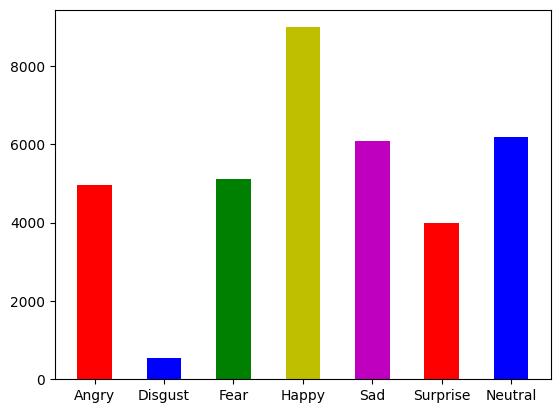

In [ ]:
#情緒資料統計
emotion_kind=[0,0,0,0,0,0,0]
for emotion in data["emotion"]:
  emotion_kind[emotion]+=1
for i in range(7):
    print(emotion_map[i] + "有" + str(emotion_kind[i]) + "筆")
plt.figure()
plt.bar(emotion_map.values(),emotion_kind,color=color,width=0.5)
plt.savefig("/content/drive/MyDrive/DL/pict/count.png")
plt.show()

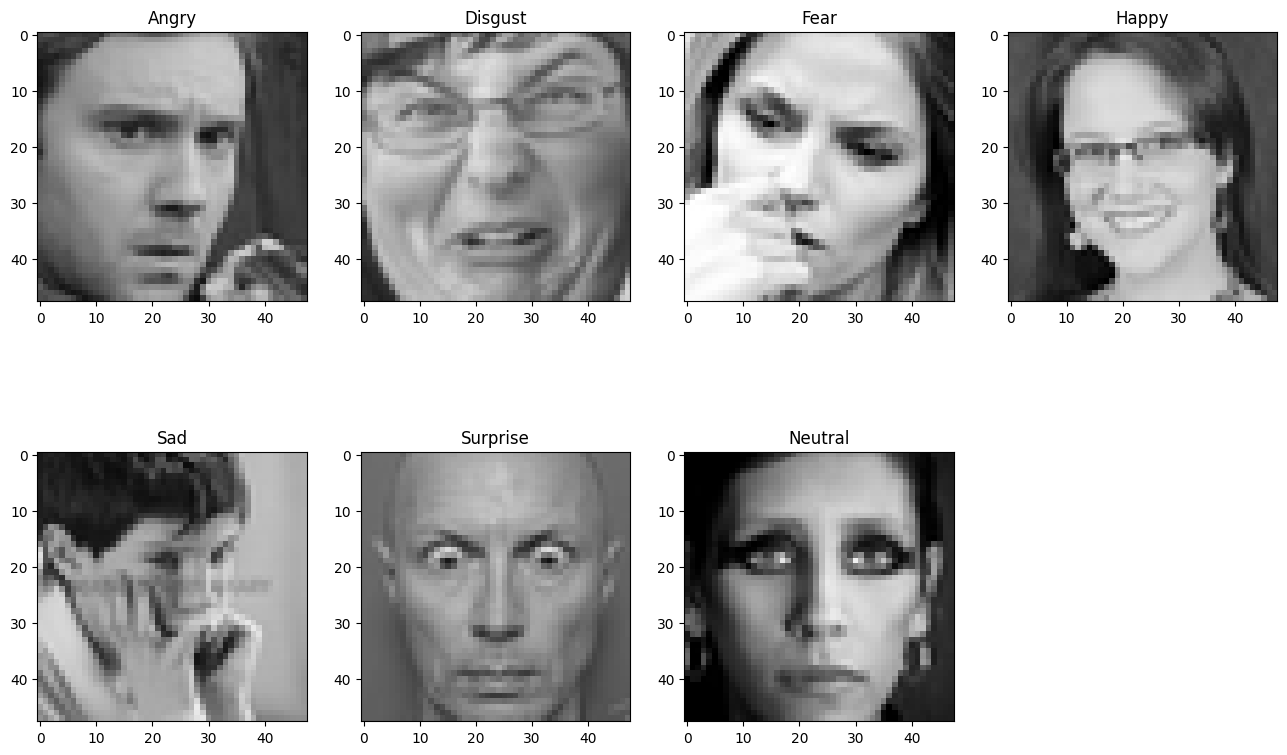

In [ ]:
#圖像顯示
def showimage(row):
  pixel,emotion=row["pixels"],emotion_map[row["emotion"]]
  img=np.array(pixel.split())
  img=np.reshape(img,(48,48))
  image=np.zeros((48,48,3))
  image[:,:,0]=img
  image[:,:,1]=img
  image[:,:,2]=img
  return image.astype(np.uint8),emotion
plt.figure(0,figsize=(16,10))
for i in range(1,8):
  face=data[data["emotion"]==i-1].iloc[0]
  img,label=showimage(face)
  plt.subplot(2,4,i)
  plt.imshow(img)
  plt.title(label)
plt.savefig("/content/drive/MyDrive/DL/pict/EMOTIONIMAGE.png")
plt.show()

數據處理

In [ ]:


def CRNO(df, dataName):
    # 過濾掉像素長度不對的資料
    df = df[df['pixels'].apply(lambda x: len(x.split()) == 48*48 if isinstance(x, str) else len(x) == 48*48)]

    # 把像素字串轉 list
    df['pixels'] = df['pixels'].apply(
        lambda x: [int(p) for p in x.split()] if isinstance(x, str) else x
    )

    # 轉成 numpy array 並正規化
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1, 48, 48, 1)
    data_X = data_X / 255.0

    # One-hot 編碼
    data_Y = to_categorical(df['emotion'], num_classes=7)

    print(f"{dataName}_X shape: {data_X.shape}, {dataName}_Y shape: {data_Y.shape}")
    return data_X, data_Y



In [ ]:
#資料分割
train_data = data[data["Usage"]=="Training"].copy()
valid_data = data[data["Usage"]=="PublicTest"].copy()
test_data = data[data["Usage"]=="PrivateTest"].copy()



train_data_x,train_data_y=CRNO(train_data,"train")
valid_data_x,valid_data_y=CRNO(valid_data,"valid")
test_data_x,test_data_y=CRNO(test_data,"test")

train_X shape: (28709, 48, 48, 1), train_Y shape: (28709, 7)
valid_X shape: (3589, 48, 48, 1), valid_Y shape: (3589, 7)
test_X shape: (3589, 48, 48, 1), test_Y shape: (3589, 7)


In [ ]:
print(test_data_x.shape)  # (35887, 48, 48, 1)
print(test_data_x[0][:,:,0])  # 顯示第一張圖的像素矩陣


(3589, 48, 48, 1)
[[0.6666667  0.4627451  0.39607844 ... 0.4392157  0.5137255  0.4862745 ]
 [0.65882355 0.49019608 0.42352942 ... 0.43529412 0.4862745  0.52156866]
 [0.6784314  0.5254902  0.44313726 ... 0.40392157 0.44705883 0.5019608 ]
 ...
 [0.32156864 0.41568628 0.3882353  ... 0.6431373  0.5176471  0.49803922]
 [0.3764706  0.4117647  0.38431373 ... 0.63529414 0.50980395 0.5176471 ]
 [0.40784314 0.40392157 0.3882353  ... 0.62352943 0.52156866 0.5137255 ]]


In [ ]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), data_format="channels_last", padding="same", input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(128, kernel_size=(3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(128, kernel_size=(3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(256, kernel_size=(3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, kernel_size=(3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(512, kernel_size=(3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation="relu", kernel_regularizer=l2()))
model.add(Dropout(0.1))  # 這裡的 rate_drop 你可以用變數或直接填數值
model.add(Dense(4096, activation="relu", kernel_regularizer=l2()))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation="softmax", kernel_regularizer=l2))
model.compile(loss="categorical_crossentropy",optimizer=SGD(momentum=0.9,nesterov=True,learning_rate=1e-4),metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,04

 Total params: 96,966,279 (369.90 MB)

 Trainable params: 96,962,567 (369.88 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
data_generator=ImageDataGenerator(
    featurewise_std_normalization=False,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75, patience=5, verbose=1)

history = model.fit(data_generator.flow(train_data_x, train_data_y, batch_size),
    # steps_per_epoch=len(train_X) / batch_size,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=2,
    callbacks=[es, reduce_lr],
    validation_data=(valid_data_x,valid_data_y))


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


575/575 - 94s - 164ms/step - accuracy: 0.2473 - loss: 108.7771 - val_accuracy: 0.2859 - val_loss: 107.4324 - learning_rate: 1.0000e-04
Epoch 2/100
575/575 - 115s - 201ms/step - accuracy: 0.2842 - loss: 106.2462 - val_accuracy: 0.3149 - val_loss: 105.0012 - learning_rate: 1.0000e-04
Epoch 3/100
575/575 - 67s - 116ms/step - accuracy: 0.3059 - loss: 103.8255 - val_accuracy: 0.3583 - val_loss: 102.5721 - learning_rate: 1.0000e-04
Epoch 4/100
575/575 - 67s - 116ms/step - accuracy: 0.3250 - loss: 101.4659 - val_accuracy: 0.3795 - val_loss: 100.2229 - learning_rate: 1.0000e-04
Epoch 5/100
575/575 - 65s - 113ms/step - accuracy: 0.3440 - loss: 99.1703 - val_accuracy: 0.3605 - val_loss: 98.0117 - learning_rate: 1.0000e-04
Epoch 6/100
575/575 - 67s - 117ms/step - accuracy: 0.3517 - loss: 96.9268 - val_accuracy: 0.3775 - val_loss: 95.7973 - learning_rate: 1.0000e-04
Epoch 7/100
575/575 - 67s - 117ms/step - accuracy: 0.3686 - loss: 94.7327 - val_accuracy: 0.4032 - val_loss: 93.5669 - learning_rate:

In [ ]:
model.save("/content/drive/MyDrive/DL/my_model.h5")  # 儲存成 HDF5 格式
model.save("/content/drive/MyDrive/DL/my_model.keras")  # 儲存為官方推薦的新格式

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(10,10))
#accuacy
#history內的data像是dictionary
#利用ax建立子畫布
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train','Validation'],loc='upper left')
#loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model lossy')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train','Validation'],loc='upper left')
plt.savefig("/content/drive/MyDrive/DL/pict/RESULT.png")
plt.show()
